In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# # load eviction data
# from google.colab import files
# uploaded = files.upload()

# uploaded manually

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/My Drive/X999/last_five_years_311.csv'

In [4]:
# cleaning functions
def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)

def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    return df

In [5]:
complaints_df = pd.read_csv(file_path)

In [6]:
complaints_df.head(2)

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Incident Zip,Incident Address,Street Name,City,Status,Resolution Description,Resolution Action Updated Date,Borough,Latitude,Longitude,Location
0,56630971,01/26/2023 09:55:15 AM,01/26/2023 11:16:50 AM,NYPD,Blocked Driveway,Partial Access,NaN,NaN,NaN,NaN,Closed,The Police Department responded to the complai...,01/26/2023 11:16:53 AM,Unspecified,NaN,NaN,NaN
1,56675111,01/31/2023 06:26:26 AM,01/31/2023 06:53:25 AM,NYPD,Illegal Parking,Blocked Hydrant,11209.0,91 STREET,91 STREET,NaN,Closed,The Police Department responded to the complai...,01/31/2023 06:53:29 AM,BROOKLYN,NaN,NaN,NaN


In [17]:
# complaints_df.columns

In [18]:
# complaints_df = drop_unneccessary_columns(complaints_df)

In [7]:
complaints_df = clean_column_names(complaints_df)

In [8]:
complaints_df.shape, \
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5718903 entries, 0 to 5718902
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   unique_key                      int64  
 1   created_date                    object 
 2   closed_date                     object 
 3   agency                          object 
 4   complaint_type                  object 
 5   descriptor                      object 
 6   incident_zip                    float64
 7   incident_address                object 
 8   street_name                     object 
 9   city                            object 
 10  status                          object 
 11  resolution_description          object 
 12  resolution_action_updated_date  object 
 13  borough                         object 
 14  latitude                        float64
 15  longitude                       float64
 16  location                        object 
dtypes: float64(3), int64(1), ob

((5718903, 17), None)

In [9]:
complaints_df.tail(2)

,unique_key,created_date,closed_date,agency,complaint_type,descriptor,incident_zip,incident_address,street_name,city,status,resolution_description,resolution_action_updated_date,borough,latitude,longitude,location
5718901,61206236,05/19/2024 03:33:29 PM,05/19/2024 05:01:34 PM,NYPD,Blocked Driveway,Partial Access,11232.0,266 24 STREET,24 STREET,BROOKLYN,Closed,The Police Department issued a summons in resp...,05/19/2024 05:01:38 PM,BROOKLYN,40.660617,-73.996756,"(40.660617059785864, -73.99675610946323)"
5718902,61207751,05/19/2024 05:22:50 AM,05/19/2024 06:23:22 AM,NYPD,Noise - Vehicle,Car/Truck Music,11105.0,21 AVENUE,21 AVENUE,NaN,Closed,The Police Department responded to the complai...,05/19/2024 06:23:26 AM,QUEENS,NaN,NaN,NaN


In [10]:
complaints_df.created_date =  pd.to_datetime(complaints_df.created_date)
complaints_df.closed_date =  pd.to_datetime(complaints_df.closed_date)

In [12]:
complaints_df.created_date.min(), complaints_df.created_date.max(), \
complaints_df.closed_date.min(), complaints_df.closed_date.max()

# amazing

(Timestamp('2017-11-01 00:01:02'),
 Timestamp('2024-09-18 01:51:13'),
 Timestamp('2017-11-01 00:04:30'),
 Timestamp('2024-09-18 01:51:28'))

In [13]:
complaints_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'complaint_type',
       'descriptor', 'incident_zip', 'incident_address', 'street_name', 'city',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'borough', 'latitude', 'longitude', 'location'],
      dtype='object')

In [14]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5718903 entries, 0 to 5718902
Data columns (total 17 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   unique_key                      int64         
 1   created_date                    datetime64[ns]
 2   closed_date                     datetime64[ns]
 3   agency                          object        
 4   complaint_type                  object        
 5   descriptor                      object        
 6   incident_zip                    float64       
 7   incident_address                object        
 8   street_name                     object        
 9   city                            object        
 10  status                          object        
 11  resolution_description          object        
 12  resolution_action_updated_date  object        
 13  borough                         object        
 14  latitude                        float64       
 15

In [15]:
print(complaints_df.isnull().sum())

unique_key                             0
created_date                           0
closed_date                         1067
agency                                 0
complaint_type                         0
descriptor                             1
incident_zip                        4260
incident_address                   63730
street_name                        63732
city                              219996
status                                 0
resolution_description             27264
resolution_action_updated_date     27913
borough                                0
latitude                           31347
longitude                          31347
location                           31347
dtype: int64


In [17]:
# drop rows that have NaN in geo data columns
complaints_df_cleaned = complaints_df.dropna(subset=['latitude', 'longitude'])

In [18]:
complaints_df_cleaned.shape, \
complaints_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5687556 entries, 2 to 5718901
Data columns (total 17 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   unique_key                      int64         
 1   created_date                    datetime64[ns]
 2   closed_date                     datetime64[ns]
 3   agency                          object        
 4   complaint_type                  object        
 5   descriptor                      object        
 6   incident_zip                    float64       
 7   incident_address                object        
 8   street_name                     object        
 9   city                            object        
 10  status                          object        
 11  resolution_description          object        
 12  resolution_action_updated_date  object        
 13  borough                         object        
 14  latitude                        float64       
 15  lon

((5687556, 17), None)

In [19]:
complaints_df_cleaned.head(1)

,unique_key,created_date,closed_date,agency,complaint_type,descriptor,incident_zip,incident_address,street_name,city,status,resolution_description,resolution_action_updated_date,borough,latitude,longitude,location
2,56656038,2023-01-29 19:20:58,2023-01-29 20:03:25,NYPD,Blocked Driveway,No Access,11368.0,108-24 35 AVENUE,35 AVENUE,CORONA,Closed,The Police Department issued a summons in resp...,01/29/2023 08:03:30 PM,QUEENS,40.755474,-73.860148,"(40.755473568461184, -73.86014798104773)"


['Blocked Driveway' 'Illegal Parking' 'Noise - Residential'
 'Noise - Vehicle']


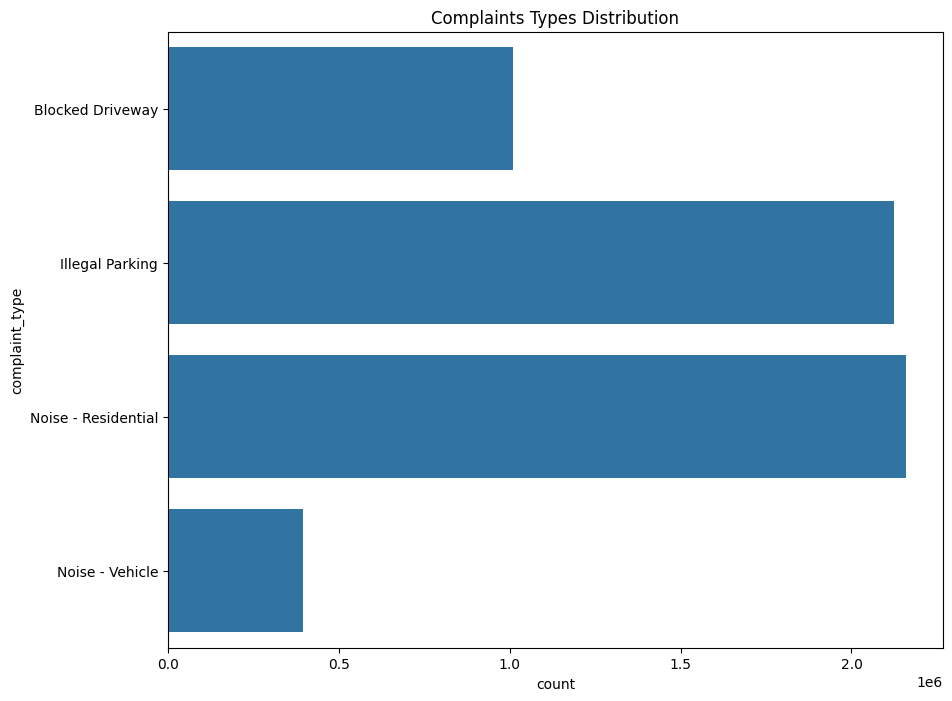

In [26]:
print(complaints_df_cleaned.complaint_type.unique())
plt.figure(figsize=(10,8))
plt.title('Complaints Types Distribution')
sns.countplot(y='complaint_type', data=complaints_df_cleaned)
plt.show()

In [35]:
# complaints_df.isna().sum().where(lambda x:x>0).dropna()

In [ ]:
# oausou

In [29]:
# cleaning idea: https://www.kaggle.com/code/riyapatel1697/nyc-311-customer-service-requests-analysis
#dropping rows where closed and resolution date both are empty
complaints_df_clean = complaints_df_cleaned[~(complaints_df_cleaned['closed_date'].isna() & complaints_df_cleaned['resolution_action_updated_date'].isna())]
#updating closed date with resolution date where closed date is empty and vice versa
complaints_df_clean.loc[complaints_df_clean['closed_date'].isna(),'closed_date'] = complaints_df_cleaned[complaints_df_cleaned['closed_date'].isna()]['resolution_action_updated_date']
complaints_df_clean.loc[complaints_df_clean['resolution_action_updated_date'].isna(),'resolution_action_updated_date'] = complaints_df_cleaned[complaints_df_cleaned['resolution_action_updated_date'].isna()]['closed_date']

In [30]:
complaints_df_cleaned.shape, \
complaints_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5687556 entries, 2 to 5718901
Data columns (total 17 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   unique_key                      int64         
 1   created_date                    datetime64[ns]
 2   closed_date                     datetime64[ns]
 3   agency                          object        
 4   complaint_type                  object        
 5   descriptor                      object        
 6   incident_zip                    float64       
 7   incident_address                object        
 8   street_name                     object        
 9   city                            object        
 10  status                          object        
 11  resolution_description          object        
 12  resolution_action_updated_date  object        
 13  borough                         object        
 14  latitude                        float64       
 15  lon

((5687556, 17), None)

In [31]:
complaints_df_cleaned.isna().sum().where(lambda x:x>0).dropna()

,0
closed_date,600.0
descriptor,1.0
incident_zip,1673.0
incident_address,59958.0
street_name,59960.0
city,193033.0
resolution_description,27255.0
resolution_action_updated_date,27024.0


In [32]:
complaints_df_cleaned.shape, \
complaints_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5687556 entries, 2 to 5718901
Data columns (total 17 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   unique_key                      int64         
 1   created_date                    datetime64[ns]
 2   closed_date                     datetime64[ns]
 3   agency                          object        
 4   complaint_type                  object        
 5   descriptor                      object        
 6   incident_zip                    float64       
 7   incident_address                object        
 8   street_name                     object        
 9   city                            object        
 10  status                          object        
 11  resolution_description          object        
 12  resolution_action_updated_date  object        
 13  borough                         object        
 14  latitude                        float64       
 15  lon

((5687556, 17), None)

In [33]:
complaints_df_cleaned.dropna(inplace=True)

In [39]:
complaints_df_cleaned.loc[:,'request_closing_time_in_hours'] = (complaints_df_cleaned['closed_date'] - complaints_df_cleaned['created_date']).dt.total_seconds()

In [40]:
complaints_df_cleaned.shape, \
complaints_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5408672 entries, 2 to 5718901
Data columns (total 18 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   unique_key                      int64         
 1   created_date                    datetime64[ns]
 2   closed_date                     datetime64[ns]
 3   agency                          object        
 4   complaint_type                  object        
 5   descriptor                      object        
 6   incident_zip                    float64       
 7   incident_address                object        
 8   street_name                     object        
 9   city                            object        
 10  status                          object        
 11  resolution_description          object        
 12  resolution_action_updated_date  object        
 13  borough                         object        
 14  latitude                        float64       
 15  lon

((5408672, 18), None)

In [41]:
complaints_df_cleaned.complaint_type.unique()

array(['Blocked Driveway', 'Noise - Residential', 'Illegal Parking',
       'Noise - Vehicle'], dtype=object)

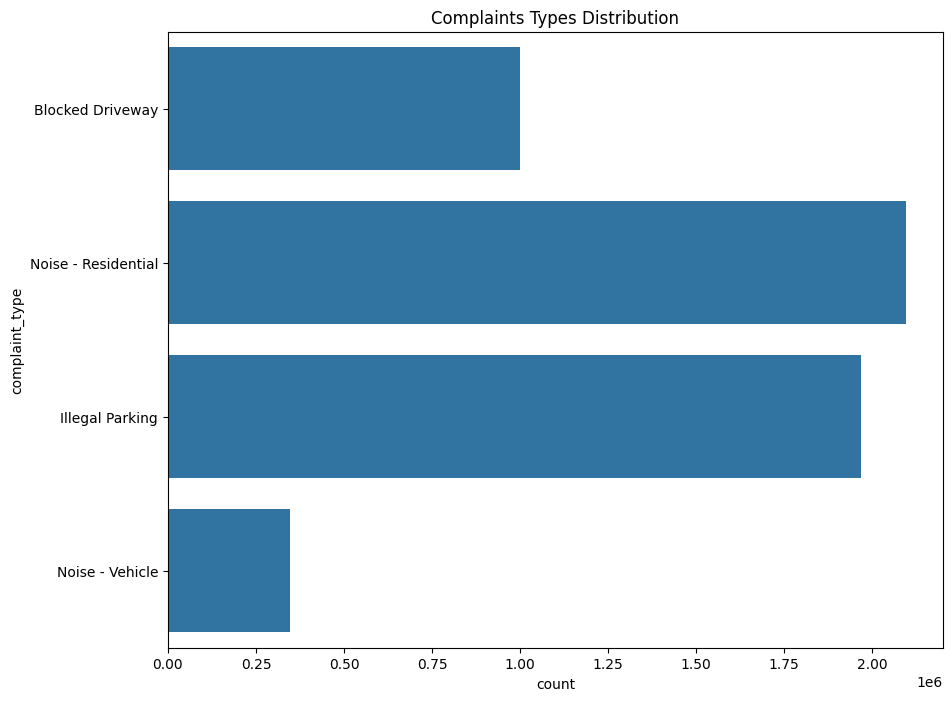

In [43]:
complaints_df_cleaned.complaint_type.unique()
plt.figure(figsize=(10,8))
plt.title('Complaints Types Distribution')
sns.countplot(y='complaint_type', data=complaints_df_cleaned)
plt.show()

In [44]:
# save cleaned 311 complaints data to my drive
complaints_df_cleaned.to_csv('/content/drive/My Drive/X999/complaints_df_cleaned.csv', index=False)

In [46]:
complaints_df_cleaned.head(100)

,unique_key,created_date,closed_date,agency,complaint_type,descriptor,incident_zip,incident_address,street_name,city,status,resolution_description,resolution_action_updated_date,borough,latitude,longitude,location,request_closing_time_in_hours
2,56656038,2023-01-29 19:20:58,2023-01-29 20:03:25,NYPD,Blocked Driveway,No Access,11368.0,108-24 35 AVENUE,35 AVENUE,CORONA,Closed,The Police Department issued a summons in resp...,01/29/2023 08:03:30 PM,QUEENS,40.755474,-73.860148,"(40.755473568461184, -73.86014798104773)",2547.0
5,56664283,2023-01-30 16:05:07,2023-01-30 17:12:27,NYPD,Blocked Driveway,No Access,10467.0,3012 MATTHEWS AVENUE,MATTHEWS AVENUE,BRONX,Closed,The Police Department issued a summons in resp...,01/30/2023 05:12:33 PM,BRONX,40.870030,-73.862424,"(40.87003012005443, -73.86242356367603)",4040.0
7,61799618,2024-07-14 16:54:34,2024-07-14 20:48:49,NYPD,Noise - Residential,Loud Music/Party,10466.0,655 EAST 230 STREET,EAST 230 STREET,BRONX,Closed,The Police Department responded to the complai...,07/14/2024 08:48:54 PM,BRONX,40.891872,-73.860168,"(40.89187241649303, -73.86016845296459)",14055.0
8,61470415,2024-06-13 21:51:36,2024-06-13 22:16:53,NYPD,Noise - Residential,Loud Talking,11103.0,30-09 45 STREET,45 STREET,ASTORIA,Closed,The Police Department responded to the complai...,06/13/2024 10:16:57 PM,QUEENS,40.761785,-73.911163,"(40.76178497199879, -73.91116286974696)",1517.0
9,62065542,2024-08-09 14:19:43,2024-08-14 02:56:32,NYPD,Illegal Parking,Posted Parking Sign Violation,11420.0,133-19 135 PLACE,135 PLACE,SOUTH OZONE PARK,Closed,The Police Department responded to the complai...,08/14/2024 02:56:35 AM,QUEENS,40.668795,-73.802632,"(40.668794673260436, -73.8026317548681)",391009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,61415542,2024-06-08 12:05:17,2024-06-08 13:44:09,NYPD,Noise - Residential,Loud Music/Party,10453.0,1605 NELSON AVENUE,NELSON AVENUE,BRONX,Closed,The Police Department responded to the complai...,06/08/2024 01:44:12 PM,BRONX,40.846224,-73.919584,"(40.84622442205441, -73.91958365636393)",5932.0
101,62107024,2024-08-13 23:58:46,2024-08-14 02:28:20,NYPD,Noise - Residential,Banging/Pounding,10468.0,2875 SEDGWICK AVENUE,SEDGWICK AVENUE,BRONX,Closed,The Police Department responded to the complai...,08/14/2024 02:28:25 AM,BRONX,40.874492,-73.901495,"(40.87449179127863, -73.90149519017201)",8974.0
102,62107025,2024-08-14 00:55:04,2024-08-14 01:55:18,NYPD,Noise - Residential,Loud Music/Party,11420.0,134-07 135 STREET,135 STREET,SOUTH OZONE PARK,Closed,The Police Department responded to the complai...,08/14/2024 01:55:25 AM,QUEENS,40.668159,-73.803542,"(40.668159441462706, -73.8035420289094)",3614.0
103,62107026,2024-08-13 22:35:34,2024-08-14 03:23:39,NYPD,Noise - Residential,Loud Music/Party,10463.0,3220 NETHERLAND AVENUE,NETHERLAND AVENUE,BRONX,Closed,The Police Department responded to the complai...,08/14/2024 03:23:44 AM,BRONX,40.884197,-73.911459,"(40.88419685955507, -73.91145858515962)",17285.0
